# Test for bike trafic model

In [3]:
import sys
from pathlib import Path

# Trouve le dossier racine du projet (celui qui contient 'src')
project_root = Path().resolve().parents[0]  # si ton notebook est dans 'notebook/'
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

import pandas as pd
#
# import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from bike import indicators as ind
from bike import utils as ut
import matplotlib.cm as cm

from aequilibrae.paths import RouteChoice
from aequilibrae.matrix import AequilibraeMatrix

from utils_traffic import *


In [4]:
def simple_bi(graph, impact_coeff = 0.8):
    for u, v, d in graph.edges(data=True):
        if d['bikes']:
            d['length_bi']= d['length']*impact_coeff
        else:
            d['length_bi']= d['length']*(2-impact_coeff)
    return graph


def estimate_traffic (graph):
    for u,v,d in graph.edges(data=True):
        if d['type_car']=='primary':
            d['traffic']= 500
        elif d['type_car']=='secondary':
            d['traffic']=250
        else :
            d['traffic']=100

def pl_type_bike(type):
    if type == 'bike_lane' :
        return 0.9
    elif type == 'bike_path':
        return 0.7
    else :
        return 1.2

def pl_slope(slope):
    if abs(slope) > 0.6:
        return 1.1
    else:
        return 1
    
def pl_green(gb_coverage):
    if gb_coverage > 0.5:
        return 0.9
    else :
        return 1
    
def pl_traffic(traffic):
    if traffic > 251:
        return 1.3
    elif traffic < 100:
        return 1
    else :
        return 1.1
    

def simple_bi_2(graph):
    for u,v,d in graph.edges(data=True):
        perceived_l = 0
        perceived_l += pl_type_bike(d['type_bike'])
        perceived_l += pl_slope(d['slope'])
        perceived_l += pl_green(d['green_blue_coverage'])
        perceived_l += pl_traffic(d['traffic'])
        d['length_bi'] = perceived_l/4



def traffic_assigment(graph, origin, destination, demand, weight='length', print_path=False):
    for u, v, d in graph.edges(data=True):
        if 'flow' not in d:
            d['flow'] = 0
    #shortest path calculation based on 'weight' attribute
    path = nx.shortest_path(graph, source=origin, target=destination, weight=weight)
    #increment traffic on each edge in the path
    for i in range(len(path)-1):
        u = path[i]
        v = path[i+1]
        graph[u][v]['flow'] += demand
        #try :
        #    graph[u][v]['flow'] += demand
        #except KeyError:
        #    graph[u][v][key]['flow'] += demand
    if print_path:
        return path

In [5]:
def generate_od_matrix(G, weight_0=0.4):    
    zones = G.nodes()
    valeurs = np.arange(0, 11)
    poids = [weight_0] + [(1 - weight_0)/10] * 10

    matrice = np.random.choice(valeurs, size=(len(zones), len(zones)), p=poids)
    np.fill_diagonal(matrice, 0)
    # Créer un DataFrame pour plus de lisibilité
    od_matrix = pd.DataFrame(matrice, index=zones, columns=zones)

    return od_matrix

In [41]:
G = nx.read_graphml("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/big_grid_graph.graphml")
pos_big_city = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

In [42]:
# Pour réinitialiser les index des nodes dans G, on peut créer un nouveau graphe avec des index numériques
G_reset = nx.convert_node_labels_to_integers(G, label_attribute='old_id')
pos_reset = {n: (d['x'], d['y']) for n, d in G_reset.nodes(data=True)}

# Afficher les nouveaux index et l'ancien id
for n, d in G_reset.nodes(data=True):
    print(f"New index: {n}, Old id: {d['old_id']}")

New index: 0, Old id: 11
New index: 1, Old id: 21
New index: 2, Old id: 31
New index: 3, Old id: 41
New index: 4, Old id: 51
New index: 5, Old id: 61
New index: 6, Old id: 71
New index: 7, Old id: 81
New index: 8, Old id: 91
New index: 9, Old id: 101
New index: 10, Old id: 111
New index: 11, Old id: 121
New index: 12, Old id: 131
New index: 13, Old id: 141
New index: 14, Old id: 151
New index: 15, Old id: 161
New index: 16, Old id: 171
New index: 17, Old id: 181
New index: 18, Old id: 191
New index: 19, Old id: 201
New index: 20, Old id: 211
New index: 21, Old id: 221
New index: 22, Old id: 231
New index: 23, Old id: 241
New index: 24, Old id: 251
New index: 25, Old id: 261
New index: 26, Old id: 12
New index: 27, Old id: 22
New index: 28, Old id: 32
New index: 29, Old id: 42
New index: 30, Old id: 52
New index: 31, Old id: 62
New index: 32, Old id: 72
New index: 33, Old id: 82
New index: 34, Old id: 92
New index: 35, Old id: 102
New index: 36, Old id: 112
New index: 37, Old id: 122
Ne

In [43]:
G = G_reset
pos_big_city = pos_reset

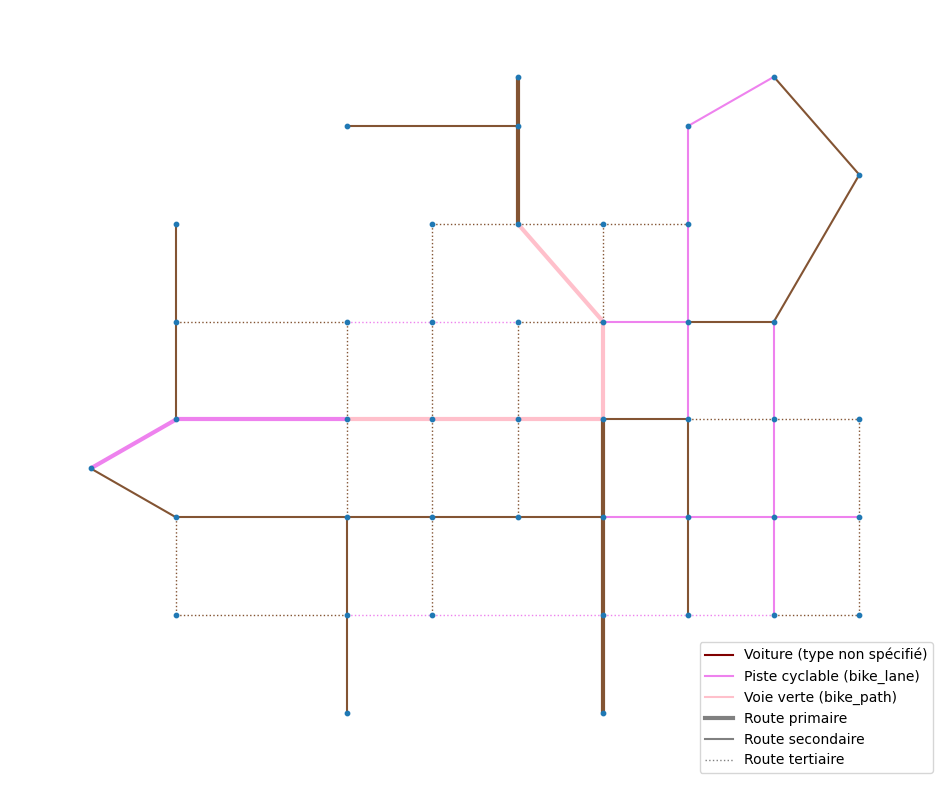

In [21]:
edge_colors = []
edge_linewidths = []
edge_linestyles = []

# Définition des styles
color_map = {'bike_lane': 'violet', 'bike_path': 'pink'}
linewidth_map = {'primary': 3, 'secondary': 1.5, 'tertiary': 1}
linestyle_map = {'primary': 'solid', 'secondary': 'solid', 'tertiary': 'dotted'}

# Valeurs par défaut si un attribut est manquant
default_color = "#835433"
default_linewidth = 0.5
default_linestyle = 'solid'

for _, _, edge in G.edges(data=True):
    # Détermination de la couleur en fonction de 'type_bike'
    bike_type = edge.get('type_bike')
    edge_colors.append(color_map.get(bike_type, default_color))

    # Détermination de l'épaisseur et du style en fonction de 'type_car'
    car_type = edge.get('type_car')
    edge_linewidths.append(linewidth_map.get(car_type, default_linewidth))
    edge_linestyles.append(linestyle_map.get(car_type, default_linestyle))

fig, ax = plt.subplots(figsize=(12, 10))
# Affichage du graphe avec les styles personnalisés
nx.draw(
    G, pos_big_city,
    edge_color=edge_colors,
    width=edge_linewidths,
    style=edge_linestyles,
    node_size=10, ax=ax
)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='maroon', lw=1.5, label='Voiture (type non spécifié)'),
    Line2D([0], [0], color='violet', lw=1.5, label='Piste cyclable (bike_lane)'),
    Line2D([0], [0], color='pink', lw=1.5, label='Voie verte (bike_path)'),
    Line2D([0], [0], color='gray', lw=3, linestyle='solid', label='Route primaire'),
    Line2D([0], [0], color='gray', lw=1.5, linestyle='solid', label='Route secondaire'),
    Line2D([0], [0], color='gray', lw=1, linestyle='dotted', label='Route tertiaire')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.show()

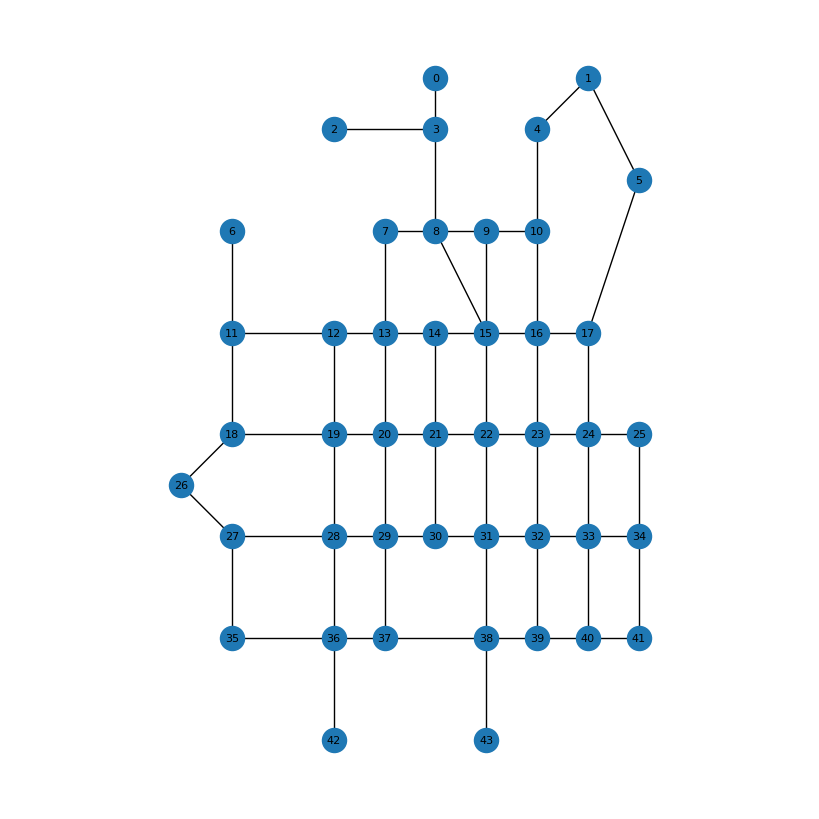

In [22]:
pos = {n: (d["x"], d["y"]) for n, d in G.nodes(data=True)}
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, with_labels=True, node_size=300, font_size=8)
plt.axis("equal")
plt.show()

In [23]:
ind.compute_all_indicators(G)

{'Size': 106.87705430228725,
 'Granularity': 1.6193493076104128,
 'Coverage': 0.32808253680973287,
 'Degree Centrality': 2.2500000000000004,
 'Betweenness Centrality': 3.1271186440677967,
 'Number of Components': 3,
 'Component Sizes': [0.178, 0.131, 0.019],
 'Connectivity': 0.5191358024691357,
 'Density 1': 0.013670105700405541,
 'Global Efficiency': 0.16253109030886811,
 'Local Efficiency': 0.0}

In [44]:
od_matrix_big_city = generate_od_matrix(G, weight_0=0.9)

In [45]:
estimate_traffic(G)
simple_bi_2(G)

In [53]:
for origin in od_matrix_big_city.index:
    for destination in od_matrix_big_city.columns:
            demand = od_matrix_big_city.loc[origin, destination]
            traffic_assigment(G, origin=origin, destination=destination, demand=demand, weight='length_bi')

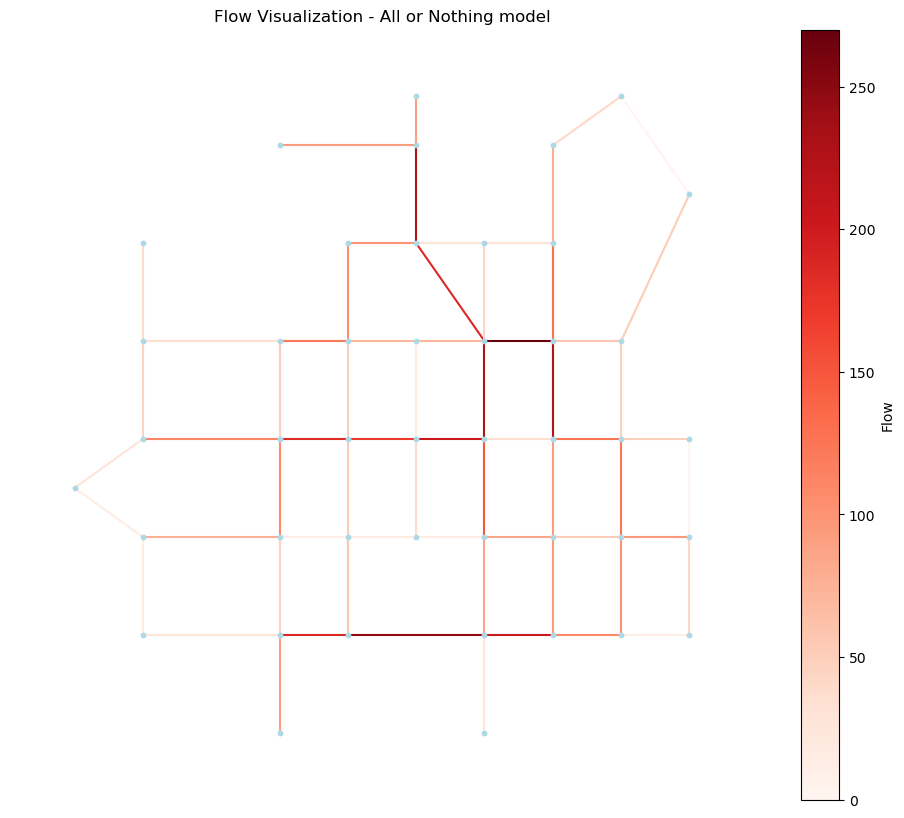

In [54]:


# Récupérer les valeurs de flow pour normaliser les couleurs
flows = [data.get('flow', 0) for u, v, data in G.edges(data=True)]
max_flow = max(flows) if flows else 1

# Créer une colormap basée sur le flow

norm = plt.Normalize(vmin=0, vmax=max_flow)
cmap = cm.Reds

edge_colors_flow = [cmap(norm(data.get('flow', 0))) for u, v, data in G.edges(data=True)]

fig, ax = plt.subplots(figsize=(12, 10))
nx.draw(G, pos_big_city, node_size=10, node_color='lightblue', 
	edge_color=edge_colors_flow, width=1.5, arrows=False, ax=ax)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Flow')
plt.title("Flow Visualization - All or Nothing model")
plt.show()

In [41]:
def code_to_int(code):
    letter = code[0]
    number = int(code[1])
    return (ord(letter) - ord('A')) * 2 + number

In [46]:
edges_df = nx.to_pandas_edgelist(G)

edges_df['travel_time']= edges_df['length_bi'] / 15
#edges_df['source'] = edges_df['source'].apply(code_to_int)
#edges_df['target'] = edges_df['target'].apply(code_to_int)
edges_df.rename(columns={'source': 'a_node'}, inplace=True) 
edges_df.rename(columns={'target': 'b_node'}, inplace=True) 
edges_df.head()

,a_node,b_node,length,lanes,length_bi,type_bike,bikes,traffic,green_blue_coverage,slope,type_car,speed,travel_time
0,0,3,1.000000,4,1.100,NaN,False,500,100.000000,0.000000,primary,80,0.073333
1,1,4,1.414214,2,1.000,bike_lane,True,250,0.000000,0.000000,secondary,50,0.066667
2,1,5,2.236068,2,1.075,NaN,False,250,0.001582,0.447214,secondary,50,0.071667
3,2,3,2.000000,2,1.050,NaN,False,250,74.998239,0.000000,secondary,50,0.070000
4,3,8,2.000000,4,1.100,NaN,False,500,75.040679,-0.500000,primary,80,0.073333


In [47]:
od_long = od_matrix_big_city.stack().reset_index()
od_long.columns = ["origin", "destination", "demand"]
od_long["origin"]

od_long.head()

,origin,destination,demand
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0


In [ ]:
results_big_grid_stochastic = traffic_assignment_stochastic_aeq(
    network_df=edges_df,
    od_df=od_long,
    time_field='travel_time',
    cost_field='length_bi',
    algorithm='bfsle',
    max_routes=1
)

Starting stochastic assignment with bfsle algorithm...
Assignment completed successfully in 0.00 seconds.
Assignment Results:
Algorithm: bfsle
Max Routes: 1
Total Travel Time: 73.41

Total Travel Cost: 1101.07



/opt/miniconda3/envs/env3/lib/python3.13/site-packages/aequilibrae/paths/route_choice.py:310: UserWarning: found unreachable OD pairs, no choice sets generated for: [(1, 14), (1, 27), (2, 11), (2, 12), (2, 28), (2, 36), (3, 5), (3, 12), (3, 14), (3, 37), (4, 22), (4, 35), (5, 2), (5, 7), (5, 14), (5, 42), (5, 43), (7, 12), (7, 18), (8, 1), (8, 36), (8, 42), (9, 2), (9, 8), (9, 20), (9, 26), (9, 27), (9, 42), (10, 4), (10, 6), (10, 13), (10, 18), (10, 37), (11, 2), (13, 2), (13, 3), (13, 18), (13, 27), (14, 29), (14, 36), (15, 8), (15, 30), (15, 35), (16, 4), (16, 6), (16, 19), (16, 21), (16, 28), (16, 31), (16, 42), (16, 43), (17, 6), (17, 20), (17, 23), (17, 28), (17, 37), (18, 5), (18, 8), (18, 16), (20, 3), (20, 10), (20, 12), (21, 2), (21, 17), (21, 18), (21, 29), (21, 36), (21, 37), (22, 6), (22, 9), (22, 29), (23, 1), (23, 10), (23, 16), (23, 22), (23, 30), (23, 42), (24, 8), (24, 19), (24, 37), (24, 42), (25, 2), (25, 8), (25, 10), (25, 13), (25, 36), (26, 11), (26, 17), (26, 23

In [49]:
flows = results_big_grid_stochastic['flow']
times = results_big_grid_stochastic['time']
network_with_flows = results_big_grid_stochastic['network']
route_choices = results_big_grid_stochastic['route_choice_results']

In [50]:
import geopandas as gpd
from shapely.geometry import Point

# Convert nodes to a GeoDataFrame
nodes_data = [{'id': node, 'x':data['x'], 'y':data['y']} for node, data in G.nodes(data=True)]
nodes_gdf = gpd.GeoDataFrame(nodes_data)
#nodes_gdf['id_int'] = nodes_gdf['id'].apply(code_to_int)
nodes_gdf = nodes_gdf.set_index('id')

nodes_gdf.head()

,x,y
id,,
0,5,13
1,8,13
2,3,12
3,5,12
4,7,12


In [51]:
G_2 = nx.from_pandas_edgelist(
    network_with_flows,
    source='a_node',
    target='b_node',
    edge_attr=True)

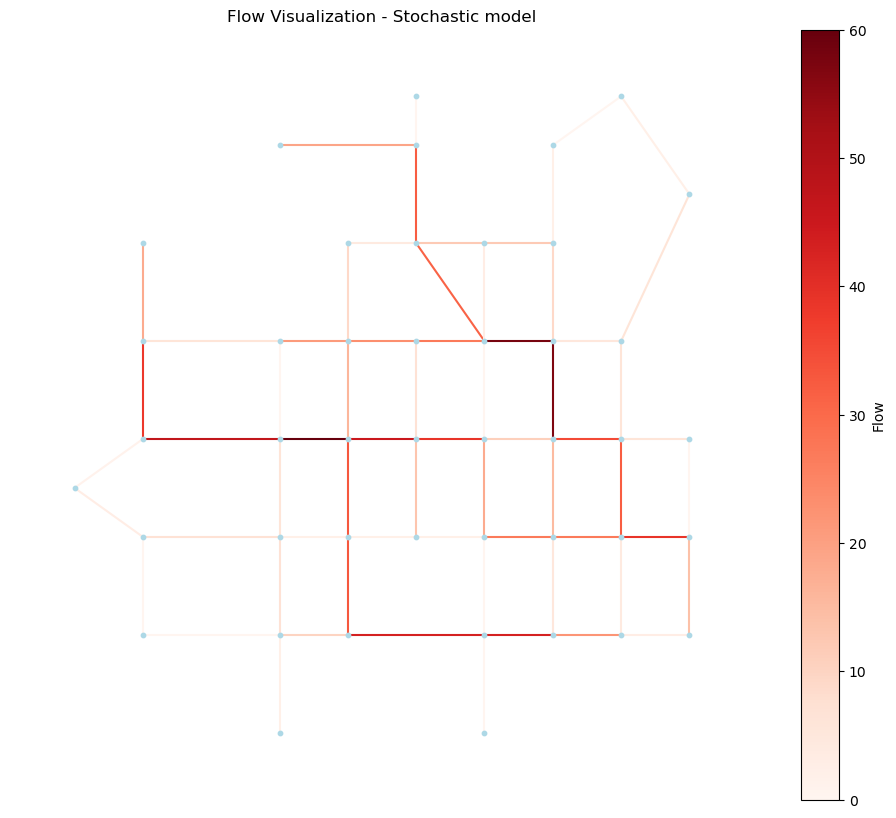

In [52]:
# Récupérer les valeurs de flow pour normaliser les couleurs
flows = [data.get('flow', 0) for u, v, data in G_2.edges(data=True)]
max_flow = max(flows) if flows else 1

# Créer une colormap basée sur le flow

norm = plt.Normalize(vmin=0, vmax=max_flow)
cmap = cm.Reds

edge_colors_flow = [cmap(norm(data.get('flow', 0))) for u, v, data in G_2.edges(data=True)]

fig, ax = plt.subplots(figsize=(12, 10))
nx.draw(G_2, pos_big_city, node_size=10, node_color='lightblue', 
	edge_color=edge_colors_flow, width=1.5, arrows=False, ax=ax)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Flow')
plt.title("Flow Visualization - Stochastic model")
plt.show()